In [39]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# plot results from disk

def plot(results_dir, graphs=False, confusion_matrix=False):
    data_list = []

    # Loop through each file in the directory
    for filename in os.listdir(results_dir):
        if filename.endswith('.json'):
            # Load the data from the JSON file
            with open(os.path.join(results_dir, filename), 'r') as file:
                data = json.load(file)
            # extract data for plotting/analysing
            model_id = data['model_id']
            train_acc_list = data.get('train_accuracy', None)
            train_loss_list = data.get('train_loss', None)
            val_acc_list = data.get('val_accuracy', None)
            val_loss_list = data.get('val_loss', None)
            best_val_acc = data['results'].get('best_acc', None)
            best_epoch = data['results'].get('best_acc_epoch', None)
            cm = np.array(data['results'].get('confusion_matrix', [])) if 'confusion_matrix' in data['results'] else None

            # Extract hyperparameters if available, otherwise set as None
            lr = data['hyperparameters'].get('learning_rate', None)
            epochs = data['hyperparameters'].get('num_epochs', None)
            batch_size = data['hyperparameters'].get('batch_size', None)
            max_len = data['hyperparameters'].get('max_len', None)
            stem_v = data['hyperparameters'].get('stem_v', None)
            pool_v = data['hyperparameters'].get('pool_v', None)
            norm_v = data['hyperparameters'].get('norm_v', None)
            dropout_rate = data['hyperparameters'].get('dropout_rate', None)
            dr = data['hyperparameters'].get('dropout', None)

            row_data = {
                'model_id': model_id,
                'learning_rate': lr,
                'num_epochs': epochs,
                'batch_size': batch_size,
                'max_len': max_len,
                'best_epoch':best_epoch,
                'stem_v':stem_v,
                'pool_v':pool_v, 
                'norm_v': norm_v, 
                'dropout_rate': dropout_rate,
                'dr': dr,
                'best_val_accuracy': best_val_acc,
            }

            data_list.append(row_data)
            if confusion_matrix:
                # Plot the confusion matrix
                disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                disp.plot()
                plt.title(f'Confusion Matrix for Model {model_id}')
                plt.show()

                # Print the classification report
                report = data['results']['classification_report']
                print(f'Classification Report for Model {model_id}:')
                print(report)

            if graphs:            
                fig, ax = plt.subplots()
                ax.plot(train_acc_list, label='Training Accuracy')
                ax.plot(val_acc_list, label='Validation Accuracy')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Accuracy')
                ax.set_title(f'Accuracy for lr {lr}, batch size {batch_size}, max len {max_len}, best ac: {best_val_acc:.2f}')
                ax.legend()
                ax.set_ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy

                # Add faint grid
                ax.set_axisbelow(True)
                ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
                # Display best accuracy in a box on the graph
                best_acc_text = f'Best Accuracy: {best_val_acc:.2f}'
                plt.text(0.05, 0.95, best_acc_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))

                # Plot the training and validation loss
                plt.figure()
                plt.plot(train_loss_list, label='Training Loss')
                plt.plot(val_loss_list, label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss for Model {model_id}')
                plt.legend()
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)  # Add faint grid
                plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
                plt.tight_layout()
                plt.show()
                
    df = pd.DataFrame(data_list)
    df.set_index('model_id', inplace=True)
    df = df.sort_values('best_val_accuracy', ascending=False)
    return df

# add hihglighting of best performance
def style_df(df):
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: yellow' if v else '' for v in is_max]

    styled_df = df.style.apply(highlight_max, subset=['best_val_accuracy'])
    return styled_df


In [52]:

# load data
bert_bin = './results/bert_binary'
bert_multi = './results/bert_multi'

bert_seq_bin = './results/bert4seq_binary'
bert_seq_mult = './results/bert4seq_multi'

w2v_bin = './results/w2v_binary'
w2v_seq = './results/w2v_multi'

In [53]:
# print the data
style_df(plot(w2v_bin,graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
960c577c-4184-4daf-a8f9-6a0643c7d14a,0.000050,100,100,None,54,False,mean,False,0.500000,None,0.767188
26990702-8e2a-4dba-bb76-b65ce5123845,0.000100,100,100,None,30,False,mean,False,0.500000,None,0.756250
57632ed8-b33a-46c6-a886-5f13df1a4415,0.000040,100,100,None,88,False,mean,False,0.500000,None,0.751563
4a82689e-4f27-4399-a4f4-4570b826bf41,0.000100,100,100,None,50,False,mean,False,0.500000,None,0.751563
139bb5ff-1e59-48a5-a46b-640fc6271d4c,0.000500,100,100,None,80,False,mean,False,0.250000,None,0.750000
2f50045f-9309-40e3-9f68-ba51c4337823,0.000500,50,100,None,18,False,mean,True,0.500000,None,0.750000
da40269a-d34c-406d-a390-11706c844562,0.000500,100,80,None,28,False,mean,False,0.500000,None,0.750000
a6d25cd8-4a7d-47e1-92bf-83427f357a20,0.000500,100,100,None,10,False,mean,False,0.500000,None,0.750000
8cc356d9-0d29-4c0d-80c1-dc5991d35620,0.000500,100,100,None,32,False,mean,False,0.500000,None,0.748437


In [42]:
style_df(plot(bert_multi, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
5e6b1a3c-b12c-4d06-87ef-a90eae819ee4,0.000010,35,25,150,34,None,None,None,None,None,0.669903
8fe23a85-c5f4-4934-8f0a-ffe324d7fdf5,0.000050,35,25,150,32,None,None,None,None,None,0.650485
08840e67-c4cd-46a0-9f9a-aab6a7275813,0.000005,35,25,150,28,None,None,None,None,None,0.640777
ccb211a9-0347-40b8-b7da-b4c325af7a6d,0.000001,60,25,150,54,None,None,None,None,None,0.592233
f0d84600-64be-4066-bb19-d4edbcca443e,0.000001,35,25,150,34,None,None,None,None,None,0.446602


In [43]:
style_df(plot(bert_seq_bin, graphs=False, confusion_matrix=False))

In [44]:
style_df(plot(bert_seq_mult, graphs=False, confusion_matrix=False))

In [45]:
style_df(plot(w2v_bin, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
960c577c-4184-4daf-a8f9-6a0643c7d14a,0.000050,100,100,None,54,False,mean,False,0.500000,None,0.767188
26990702-8e2a-4dba-bb76-b65ce5123845,0.000100,100,100,None,30,False,mean,False,0.500000,None,0.756250
57632ed8-b33a-46c6-a886-5f13df1a4415,0.000040,100,100,None,88,False,mean,False,0.500000,None,0.751563
4a82689e-4f27-4399-a4f4-4570b826bf41,0.000100,100,100,None,50,False,mean,False,0.500000,None,0.751563
139bb5ff-1e59-48a5-a46b-640fc6271d4c,0.000500,100,100,None,80,False,mean,False,0.250000,None,0.750000
2f50045f-9309-40e3-9f68-ba51c4337823,0.000500,50,100,None,18,False,mean,True,0.500000,None,0.750000
da40269a-d34c-406d-a390-11706c844562,0.000500,100,80,None,28,False,mean,False,0.500000,None,0.750000
a6d25cd8-4a7d-47e1-92bf-83427f357a20,0.000500,100,100,None,10,False,mean,False,0.500000,None,0.750000
8cc356d9-0d29-4c0d-80c1-dc5991d35620,0.000500,100,100,None,32,False,mean,False,0.500000,None,0.748437


In [46]:
style_df(plot(w2v_seq, graphs=False, confusion_matrix=False))

,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,
ab04ff24-a7f9-4c5e-a9f7-f3a876c5b3c1,0.000500,100,128,None,91,False,mean,False,0.500000,None,0.559871
f2a410b8-1880-4172-bd77-ed80c68b3a10,0.000500,100,100,None,33,False,mean,False,0.500000,None,0.550162
a20fe6f0-0e04-4020-825e-8dbe0614c20d,0.000500,100,100,None,49,False,mean,False,0.500000,None,0.550162
cef87d52-ab00-4b14-97a2-c18491f5aa6c,0.000500,100,50,None,35,False,mean,False,0.500000,None,0.550162
bd3662a8-5a6d-4030-a5c3-e4e63092d5a5,0.000500,100,100,None,83,False,mean,False,0.500000,None,0.546926
f5499e87-c02b-4378-9ae7-9347cc4472d8,0.000500,100,8,None,53,False,mean,False,0.500000,None,0.546926
7562eacd-da19-4b63-8227-aff75d3e1a68,0.000500,100,128,None,49,False,mean,False,0.500000,None,0.543689
46ed979b-bac9-4b5a-8c19-eb598514268f,0.000500,100,180,None,49,False,mean,False,0.500000,None,0.543689
a13e8cb2-d226-4f79-b9f2-5ac07a3c57b4,0.000500,100,100,None,44,True,mean,False,0.500000,None,0.543689


In [47]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# for plotting/comparing the best performing models 

def compile_best_results(results_dir, graph=False, confusion_matrix=False, task='binary', cmap= 'RdYlBu'):
    data = []

    # Loop through the subdirectories in the 'results' directory
    for subdir in os.listdir(results_dir):
        if task not in subdir:
            continue
        subdir_path = os.path.join(results_dir, subdir)
        
        # Check if the current item is a directory
        if os.path.isdir(subdir_path):
            best_acc = 0
            best_file = None
            
            # Loop through the JSON files in the subdirectory
            for file in os.listdir(subdir_path):
                if file.endswith(".json"):
                    file_path = os.path.join(subdir_path, file)
                    
                    # Load the JSON data
                    with open(file_path) as f:
                        json_data = json.load(f)
                    
                    # Check if the JSON has the 'results' key
                    if 'results' in json_data:
                        results = json_data['results']
                        
                        # Check if the 'best_acc' key exists and update the best accuracy
                        if 'best_acc' in results and results['best_acc'] > best_acc:
                            best_acc = results['best_acc']
                            best_file = file_path
            
            # If a best file was found, add its data to the list
            if best_file:
                with open(best_file) as f:
                    best_data = json.load(f)
                
                # Extract relevant information from the best-performing model
                model_id = best_data['model_id']
                best_epoch = best_data['results'].get('best_acc_epoch', None)
                
                # Extract hyperparameters if available, otherwise set as None
                lr = best_data['hyperparameters'].get('learning_rate', None)
                epochs = best_data['hyperparameters'].get('num_epochs', None)
                batch_size = best_data['hyperparameters'].get('batch_size', None)
                max_len = best_data['hyperparameters'].get('max_len', None)
                stem_v = best_data['hyperparameters'].get('stem_v', None)
                pool_v = best_data['hyperparameters'].get('pool_v', None)
                norm_v = best_data['hyperparameters'].get('norm_v', None)
                dropout_rate = best_data['hyperparameters'].get('dropout_rate', None)
                dr = best_data['hyperparameters'].get('dropout', None)

                
                # Extract additional information for graphs and confusion matrix
                train_acc_list = best_data.get('train_accuracy', None)
                train_loss_list = best_data.get('train_loss', None)
                val_acc_list = best_data.get('val_accuracy', None)
                val_loss_list = best_data.get('val_loss', None)
                cm = np.array(best_data['results'].get('confusion_matrix', [])) if 'confusion_matrix' in best_data['results'] else None
                
                # Create a dictionary with the extracted information
                row_data = {
                    'model_id': model_id,
                    'subdir': subdir,
                    'learning_rate': lr,
                    'num_epochs': epochs,
                    'batch_size': batch_size,
                    'max_len': max_len,
                    'best_epoch': best_epoch,
                    'stem_v':stem_v,
                    'pool_v':pool_v, 
                    'norm_v': norm_v, 
                    'dropout_rate': dropout_rate,
                    'dr': dr,
                    'best_val_accuracy': best_acc
                }
                
                data.append(row_data)
                print(model_id)
                if confusion_matrix and cm is not None:
                    # Plot the confusion matrix and classification report
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
                    disp.plot()
                    plt.title(f'{subdir}_classifier')
                    plt.show()
                    
                    report = best_data['results'].get('classification_report', None)
                    report_dict = parse_classification_report(report)
                    df_report = pd.DataFrame(report_dict).T
                    df_heatmap = df_report[['precision', 'recall', 'f1-score']].iloc[:8]
                    # print('DF:', df_heatmap)

                    fig, ax = plt.subplots(figsize=(10, 8))
                    heatmap = ax.imshow(df_heatmap, cmap=cmap, aspect='auto', vmin=0.4, vmax=0.85)
                    ax.set_xticks(np.arange(len(df_heatmap.columns)))
                    ax.set_xticklabels(df_heatmap.columns)
                    ax.set_yticks(np.arange(len(df_heatmap.index)))
                    ax.set_yticklabels(df_heatmap.index)
                    for i in range(len(df_heatmap.index)):
                        for j in range(len(df_heatmap.columns)):
                            ax.text(j, i, f'{df_heatmap.iloc[i, j]:.2f}', ha='center', va='center', color='w')
                    ax.set_xlabel('Metrics')
                    ax.set_ylabel('Classes')
                    ax.set_title('Classification Report Heatmap')
                    cbar = ax.figure.colorbar(heatmap, ax=ax)
                    fig.tight_layout()
                    plt.title(f'Classification Report Heatmap {subdir}_classifier')

                    plt.show()
                                    
                if graph and train_acc_list and val_acc_list and train_loss_list and val_loss_list:
                    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))
                    
                    # fig.title('Best {subdir} classifier performance over training')
                    # Accuracy plot
                    ax1.plot(train_acc_list, label='Training')
                    ax1.plot(val_acc_list, label='Validation')
                    ax1.set_xlabel('Epoch')
                    ax1.set_ylabel('Accuracy')
                    ax1.set_title(f'Accuracy')
                    ax1.legend()
                    ax1.set_ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
                    # Add faint grid
                    ax1.set_axisbelow(True)
                    ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
                    # Display best accuracy in a box on the graph
                    # best_acc_text = f'Best Accuracy: {best_acc:.2f}'
                    # ax1.text(0.05, 0.95, best_acc_text, transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.5))

                    # Loss plot
                    ax2.plot(train_loss_list, label='Training')
                    ax2.plot(val_loss_list, label='Validation')
                    ax2.set_xlabel('Epoch')
                    ax2.set_ylabel('Loss')
                    ax2.set_title(f'Loss')
                    ax2.legend()
                    ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)  # Add faint grid
                    ax2.set_ylim(0, 0.025)  # Set y-axis limits for loss
                    fig.suptitle(f'Best Performaning {subdir}_classifier over training', fontsize=16)

                    plt.tight_layout()
                    plt.show()
                        
    # Create a DataFrame from the compiled data
    df = pd.DataFrame(data)
    df.set_index('model_id', inplace=True)
    
    # Sort the DataFrame by 'best_val_accuracy' in descending order
    df.sort_values(by='best_val_accuracy', ascending=False, inplace=True)
    
    return df

# this function was required as intiially the confusion matrix data was stored as a string and so had to be parsed back into a form that was easy to plot
def parse_classification_report(report):
    report_dict = {}
    lines = report.strip().split('\n')
    for line in lines[2:]:
        if line.startswith('accuracy'):
            parts = line.split()
            accuracy = float(parts[1])  # Extract accuracy value
            report_dict['accuracy'] = accuracy
        elif line.strip() and not line.startswith(('macro', 'weighted')):
            # Process class lines, skipping "macro avg"and "weighted avg"
            parts = line.split()
            if len(parts) >= 5:
                class_name = line.rsplit(maxsplit=4)[0].strip()
                precision, recall, f1_score, support = map(float, line.rsplit(maxsplit=4)[1:])
                report_dict[class_name] = {
                    'precision': precision,
                    'recall': recall,
                    'f1-score': f1_score,
                    'support': int(support)
                }
        elif line.startswith('macro avg') or line.startswith('weighted avg'):
            parts = line.split()
            avg_type = "_".join(parts[:2])  # Combine "macro" and "avg" or "weighted" and "avg"
            precision, recall, f1_score, support = map(float, parts[2:])
            report_dict[avg_type] = {
                'precision': precision,
                'recall': recall,
                'f1-score': f1_score,
                'support': int(support)
            }
    return report_dict

5e6b1a3c-b12c-4d06-87ef-a90eae819ee4


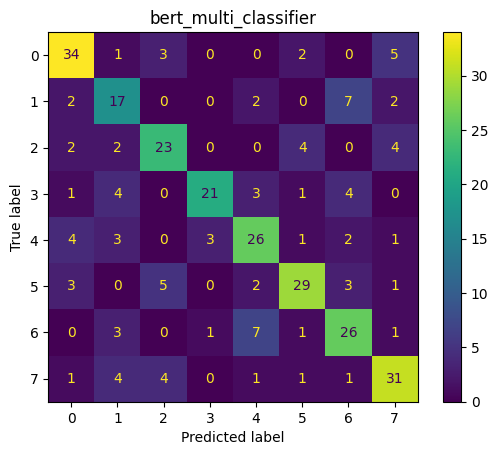

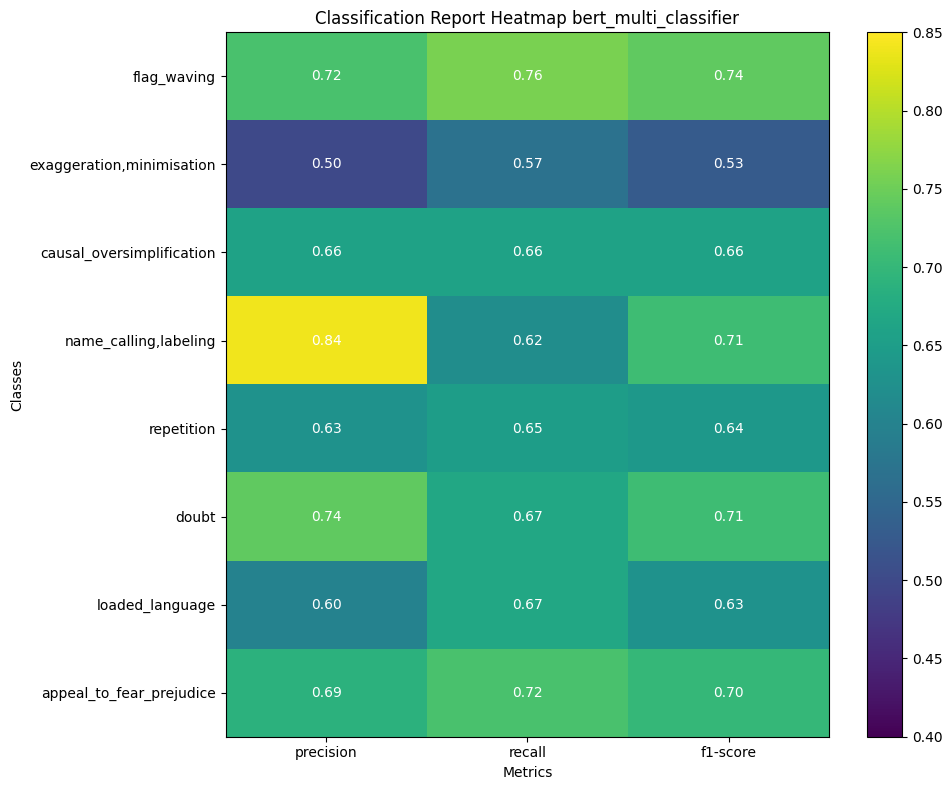

ab04ff24-a7f9-4c5e-a9f7-f3a876c5b3c1


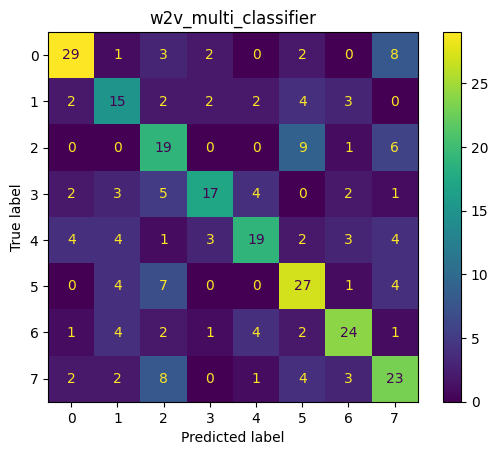

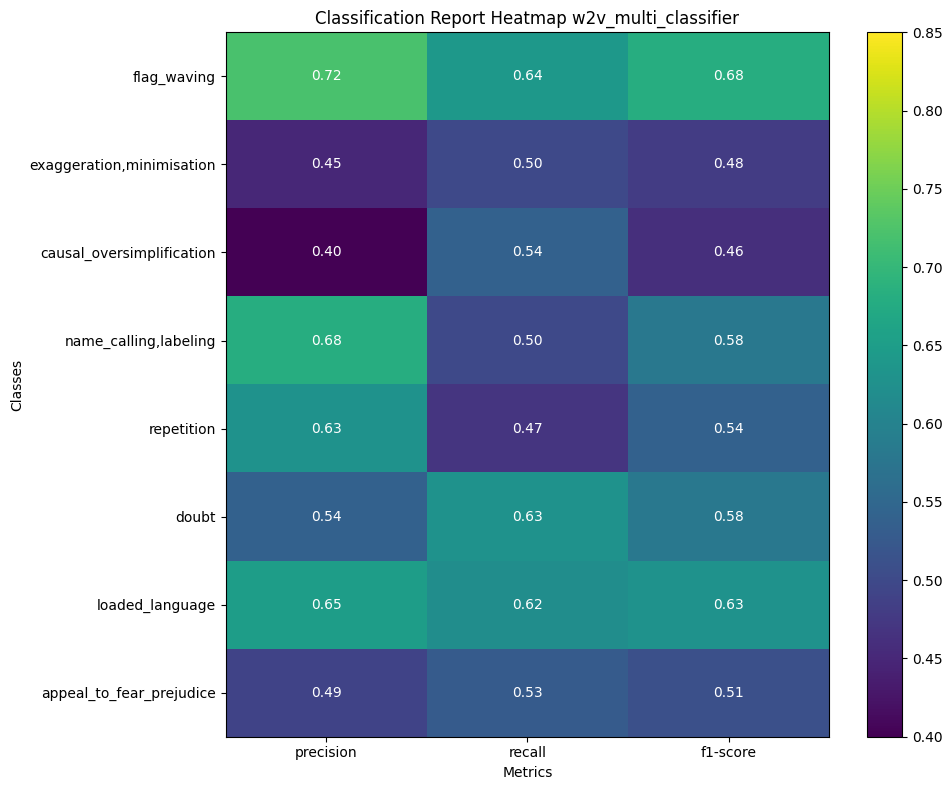

,subdir,learning_rate,num_epochs,batch_size,max_len,best_epoch,stem_v,pool_v,norm_v,dropout_rate,dr,best_val_accuracy
model_id,,,,,,,,,,,,
5e6b1a3c-b12c-4d06-87ef-a90eae819ee4,bert_multi,0.000010,35,25,150.000000,34,None,None,None,nan,None,0.669903
ab04ff24-a7f9-4c5e-a9f7-f3a876c5b3c1,w2v_multi,0.000500,100,128,nan,91,False,mean,False,0.500000,None,0.559871


In [48]:
style_df(compile_best_results('./results', graph=False, confusion_matrix=True, task='multi', cmap='viridis'))

In [49]:
bert_bin = './results/bert_binary'
bert_multi = './results/bert_multi'

bert_seq_bin = './results/bert4seq_binary'
bert_seq_mult = './results/bert4seq_multi'

w2v_bin = './results/w2v_binary'
w2v_seq = './results/w2v_multi'

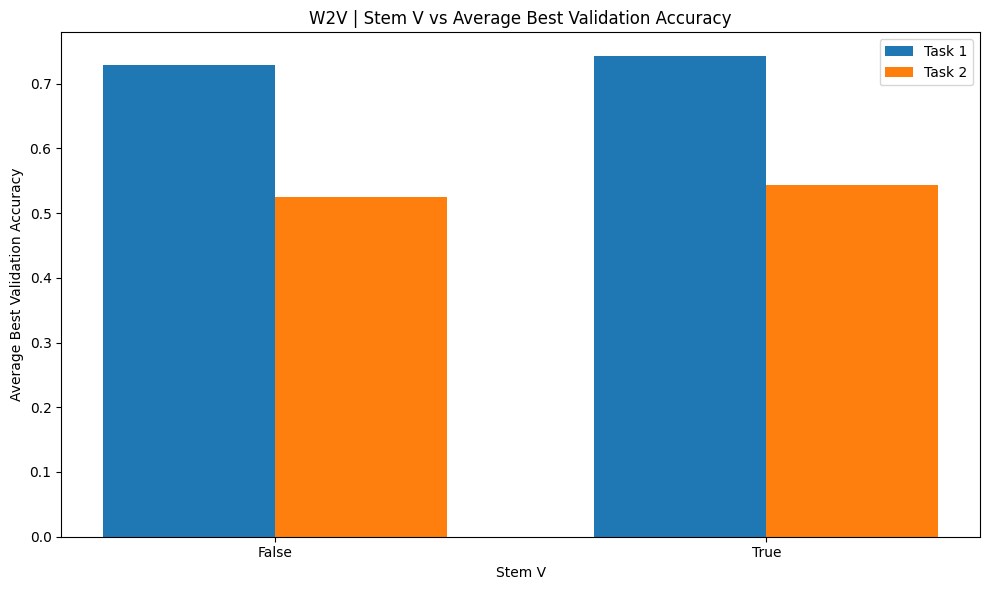

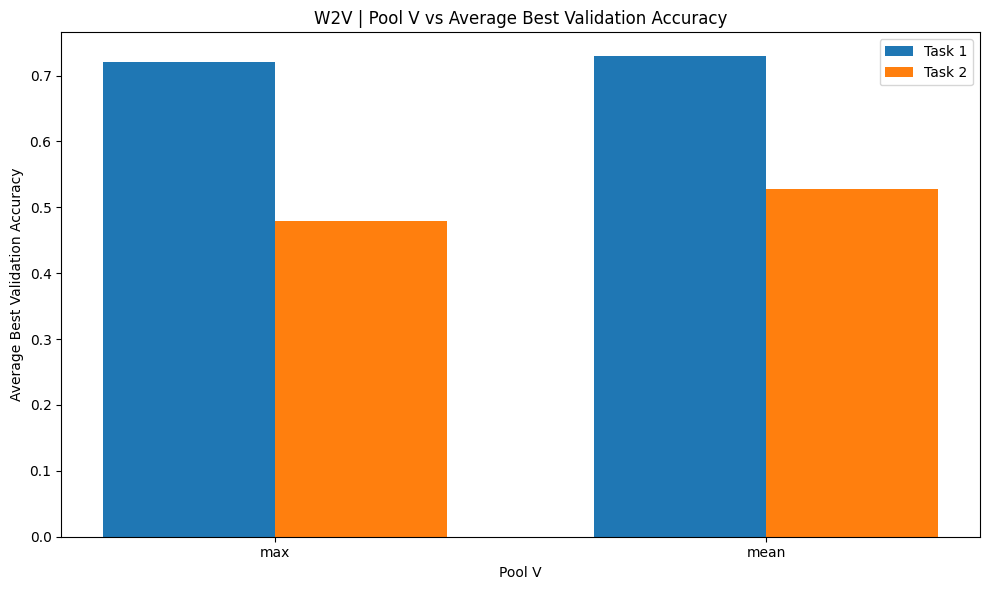

In [51]:
# for plotting effects of hyperparams

import matplotlib.pyplot as plt

def plot_dual_bar_chart(df_t1, df_t2, column, title):
    avg_t1 = df_t1.groupby(column)['best_val_accuracy'].mean()
    avg_t2 = df_t2.groupby(column)['best_val_accuracy'].mean()

    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    x = np.arange(len(avg_t1))

    plt.bar(x - bar_width / 2, avg_t1, width=bar_width, label='Task 1')
    plt.bar(x + bar_width / 2, avg_t2, width=bar_width, label='Task 2')

    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel('Average Best Validation Accuracy')
    plt.title(f'{title} | {column.replace("_", " ").title()} vs Average Best Validation Accuracy')

    plt.xticks(x, avg_t1.index)
    plt.legend()
    plt.tight_layout()
    plt.show()

new_df_t1 = plot(w2v_bin, graphs=False, confusion_matrix=False)
new_df_t2 = plot(w2v_seq, graphs=False, confusion_matrix=False)
data = 'W2V'

# Plot dual bar charts for various columns
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'batch_size', data)
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'batch_size', data)
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'learning_rate', data)
plot_dual_bar_chart(new_df_t1, new_df_t2, 'stem_v', data)
plot_dual_bar_chart(new_df_t1, new_df_t2, 'pool_v', data)
# plot_dual_bar_chart(new_df_t1, new_df_t2, 'norm_v', data)